In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Define the path to your zip file
zip_path = '/content/drive/MyDrive/anamoly_detection/Datasets_new.zip'

# Unzip the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/New__processed')

# Verify the structure
!ls /content/New__processed

Datasets_new


In [ ]:
import cv2
import os

def video_to_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    success, frame = cap.read()
    count = 0
    while success:
        frame_filename = os.path.join(output_folder, f"frame_{count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        success, frame = cap.read()
        count += 1
    cap.release()


In [ ]:
# Set the base path for the dataset
base_path = "/content/New__processed/Datasets_new"
categories = ["train", "test", "valid"]
subcategories = ["normal_videos", "Vandalism", "Fighting"]

# Create directories for frames
for category in categories:
    for subcategory in subcategories:
        video_folder = os.path.join(base_path, category, subcategory)
        output_folder = os.path.join(base_path, category, f"{subcategory}_frames")
        os.makedirs(output_folder, exist_ok=True)

        for video_file in os.listdir(video_folder):
            video_path = os.path.join(video_folder, video_file)
            video_to_frames(video_path, output_folder)


In [ ]:
import tensorflow as tf

def load_frame(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])

    # Data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper= 1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper =1.2)
    image = tf.image.random_hue(image, max_delta=0.2)

    image = image / 255.0  # Normalize to [0, 1]
    return image, label


In [ ]:
# Define label mapping
label_mapping = {
    "normal_videos": 0,
    "Vandalism": 1,
    "Fighting": 2
}

# Define paths for the dataset
train_paths = {
    "normal_videos": "/content/New__processed/Datasets_new/train/normal_videos_frames",
    "Vandalism": "/content/New__processed/Datasets_new/train/Vandalism_frames",
    "Fighting": "/content/New__processed/Datasets_new/train/Fighting_frames"
}

valid_paths = {
    "normal_videos": "/content/New__processed/Datasets_new/valid/normal_videos_frames",
    "Vandalism": "/content/New__processed/Datasets_new/valid/Vandalism_frames",
    "Fighting": "/content/New__processed/Datasets_new/valid/Fighting_frames"
}

test_paths = {
    "normal_videos": "/content/New__processed/Datasets_new/test/normal_videos_frames",
    "Vandalism": "/content/New__processed/Datasets_new/test/Vandalism_frames",
    "Fighting": "/content/New__processed/Datasets_new/test/Fighting_frames"
}


In [ ]:
def build_labeled_sequence_dataset(folder_path, label, sequence_length):
    image_paths = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith('.jpg')])

    # Ensure we have enough frames to form at least one full sequence
    num_sequences = len(image_paths) // sequence_length
    sequences = []

    for i in range(num_sequences):
        sequence = image_paths[i*sequence_length:(i+1)*sequence_length]
        sequences.append(sequence)

    # Create TensorFlow dataset
    def gen():
        for sequence in sequences:
            yield sequence, label

    dataset = tf.data.Dataset.from_generator(gen, output_signature=(
        tf.TensorSpec(shape=(sequence_length,), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    ))

    dataset = dataset.map(lambda seq, lbl: (tf.map_fn(lambda img_path: load_frame(img_path, lbl)[0], seq, dtype=tf.float32), lbl))
    return dataset


In [ ]:
def build_combined_dataset(paths, sequence_length=64, batch_size=8, cache=False):
    datasets = []
    for subcategory, folder_path in paths.items():
        label = label_mapping[subcategory]
        dataset = build_labeled_sequence_dataset(folder_path, label, sequence_length)
        datasets.append(dataset)

    combined_dataset = datasets[0]
    for ds in datasets[1:]:
        combined_dataset = combined_dataset.concatenate(ds)

    if cache:
        combined_dataset = combined_dataset.cache()
    combined_dataset = combined_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return combined_dataset

# Build datasets with new batch size
train_dataset = build_combined_dataset(train_paths, batch_size=8)
valid_dataset = build_combined_dataset(valid_paths, batch_size=8)
test_dataset = build_combined_dataset(test_paths, batch_size=8)


Instructions for updating:
Use fn_output_signature instead


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.mixed_precision import Policy, set_global_policy

# Enable mixed precision
policy = Policy('mixed_float16')
set_global_policy(policy)

def build_i3d_model(input_shape=(64, 224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape[1:])
    base_model.trainable = False

    time_distributed_features = layers.TimeDistributed(base_model)(inputs)
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(time_distributed_features)
    x = layers.LSTM(512, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=inputs, outputs=predictions)
    return model

input_shape = (64, 224, 224, 3)
num_classes = 3
i3d_model = build_i3d_model(input_shape=input_shape, num_classes=num_classes)

i3d_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

i3d_model.summary()


87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 224, 224, 3   0         
                             )]                                  
                                                                 
 time_distributed (TimeDist  (None, 64, 5, 5, 2048)    21802784  
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 64, 2048)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 512)               5244928   
                                                                 
 dense (Dense)               (None, 512)               262656 

In [ ]:
num_epochs = 50
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   factor=0.5,
                                                   patience=5,
                                                   min_lr=1e-6,
                                                   verbose=1)

history = i3d_model.fit(train_dataset,
                        epochs=num_epochs,
                        validation_data=valid_dataset,
                        callbacks=[lr_schedule])


Epoch 1/50
102/102 [==============================] - 89s 659ms/step - loss: 22.1428 - accuracy: 0.8125 - val_loss: 20.7295 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 2/50
102/102 [==============================] - 60s 593ms/step - loss: 17.2652 - accuracy: 0.5956 - val_loss: 15.4741 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 3/50
102/102 [==============================] - 60s 592ms/step - loss: 13.2435 - accuracy: 0.5797 - val_loss: 12.3125 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 4/50
102/102 [==============================] - 60s 592ms/step - loss: 10.4711 - accuracy: 0.5368 - val_loss: 9.8620 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 5/50
102/102 [==============================] - 60s 592ms/step - loss: 8.4216 - accuracy: 0.5699 - val_loss: 8.3408 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 6/50
102/102 [==============================] - 61s 594ms/step - loss: 6.9181 - accuracy: 0.5919 - val_loss: 6.9942 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 7/50
102/102 [=

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save the model to drive
model_save_path = '/content/drive/MyDrive/i3d_model(final).keras'
i3d_model.save(model_save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


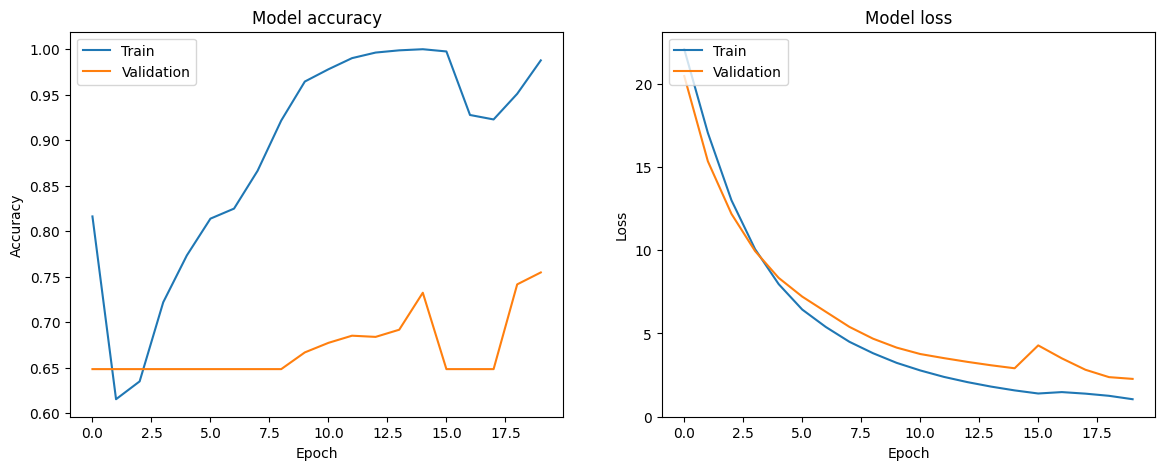

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for videos, labels in valid_dataset:
    predictions = i3d_model.predict(videos)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Generate classification report
print(classification_report(y_true, y_pred, target_names=['normal', 'fighting', 'vandalism']))


1/1 [==============================] - 0s 65ms/step
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       156
    fighting       0.39      0.85      0.54       112
   vandalism       0.93      0.97      0.95       494

    accuracy                           0.76       762
   macro avg       0.44      0.61      0.50       762
weighted avg       0.66      0.76      0.69       762



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Load the saved model
from tensorflow.keras.models import load_model
i3d_model = load_model('/content/drive/MyDrive/i3d_model(final).keras')


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


Epoch 1/40
102/102 [==============================] - 55s 539ms/step - loss: 0.1508 - accuracy: 1.0000 - val_loss: 3.2768 - val_accuracy: 0.4291 - lr: 6.2500e-06
Epoch 2/40
102/102 [==============================] - 54s 534ms/step - loss: 0.1491 - accuracy: 1.0000 - val_loss: 3.3060 - val_accuracy: 0.4318 - lr: 6.2500e-06
Epoch 3/40
102/102 [==============================] - 54s 535ms/step - loss: 0.1472 - accuracy: 1.0000 - val_loss: 3.3376 - val_accuracy: 0.4252 - lr: 6.2500e-06
Epoch 4/40
102/102 [==============================] - 54s 535ms/step - loss: 0.1452 - accuracy: 1.0000 - val_loss: 3.3990 - val_accuracy: 0.4029 - lr: 6.2500e-06
Epoch 5/40
102/102 [==============================] - 55s 535ms/step - loss: 0.1432 - accuracy: 1.0000 - val_loss: 3.5317 - val_accuracy: 0.3780 - lr: 6.2500e-06
Epoch 6/40
102/102 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
102/102 [==========

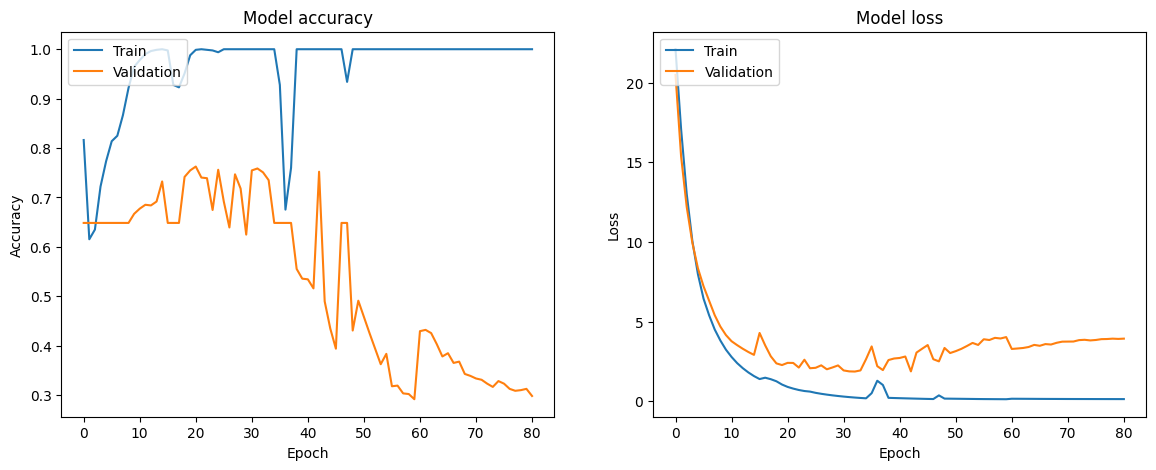

In [ ]:
# Set a higher number of epochs
additional_epochs = 40

# Continue training the model
history_additional = i3d_model.fit(train_dataset,
                                   epochs=additional_epochs,
                                   validation_data=valid_dataset,
                                   callbacks=[lr_schedule, early_stopping])

# Save the updated model
i3d_model.save(model_save_path)

# Combine the histories
history.history['accuracy'].extend(history_additional.history['accuracy'])
history.history['val_accuracy'].extend(history_additional.history['val_accuracy'])
history.history['loss'].extend(history_additional.history['loss'])
history.history['val_loss'].extend(history_additional.history['val_loss'])

# Plot the combined history
plot_training_history(history)


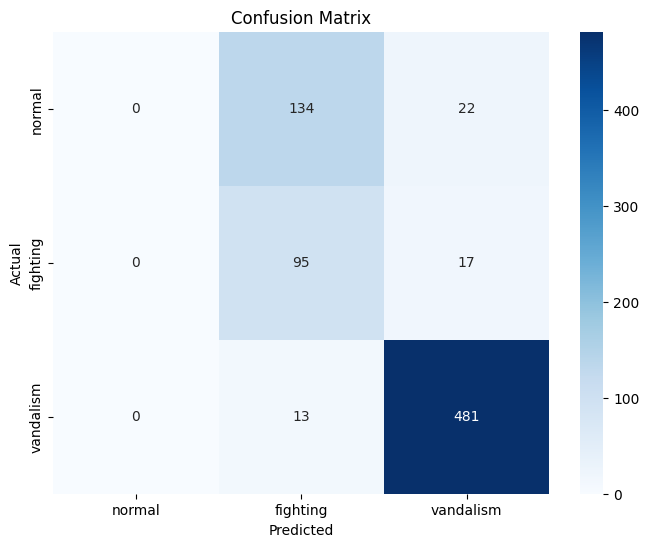

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'fighting', 'vandalism'], yticklabels=['normal', 'fighting', 'vandalism'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the current model
i3d_model.save('/content/drive/MyDrive/i3d_model_v2.keras')


In [ ]:
from tensorflow.keras.models import load_model

i3d_model = load_model('/content/drive/MyDrive/i3d_model_v2.keras')


In [ ]:
from tensorflow.keras.layers import Dropout, Dense

# Example of modifying a model to add Dropout layers (adjust according to your actual model definition)
def add_dropout_to_model(model, dropout_rate=0.5):
    for layer in model.layers:
        if 'conv' in layer.name or 'dense' in layer.name:
            layer.trainable = True
            x = Dropout(dropout_rate)(layer.output)
            new_layer = Dense(layer.units, activation=layer.activation)(x)
            model = Model(inputs=model.input, outputs=new_layer)
    return model

i3d_model = add_dropout_to_model(i3d_model)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
